In [621]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D

import time
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
import torch
import itertools

#from scipy.spatial.transform import Rotation as R

from tracking_utils import *
from arm_utils import search_cuboid

np.seterr(all="ignore")

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

# camera intrinsics/rig extrinsics 
## (to be modified to pull live data in the future)

In [2]:
intrinsics = load_lut("data/Depth AHaT_lut.bin")
intrinsics_map = np.reshape(intrinsics, (512, 512, -1))

right_intrinsics = load_lut("data/VLC RF_lut.bin")
right_intrinsics = np.reshape(right_intrinsics, (480, 640, -1)) # correct order?
right_intrinsics = np.flip(right_intrinsics, axis=1) # need flip?
riflat = np.reshape(right_intrinsics, (-1,3))

left_intrinsics = load_lut("data/VLC LF_lut.bin")
left_intrinsics = np.reshape(left_intrinsics, (480, 640, -1)) # correct order?
left_intrinsics = np.flip(left_intrinsics, axis=0) # need flip?
liflat = np.reshape(left_intrinsics, (-1,3))

r2d = load_r2c("data/Depth AHaT_extrinsics.txt")
d2r = np.linalg.inv(r2d)
r2right = load_r2c("data/VLC RF_extrinsics.txt")
r2left = load_r2c("data/VLC LF_extrinsics.txt")
d2right = r2right.dot(d2r)
d2left = r2left.dot(d2r)

# load ellipse segmentation model

In [3]:
DEVICE = torch.device('cuda')
ellipsegnet = EllipSegNet(16, 1)
ellipsegnet.load_state_dict(torch.load('py_ellipsegnet.pt', map_location=DEVICE))
ellipsegnet.to(DEVICE)
ellipsegnet.eval()
print('loaded')

loaded


# get pose data (cam2world) for specified session

In [4]:
# time in ms
# transforms in metres
session_name = "14-01-2022-15-48-40"
#14-01-2022-12-22-15
#14-01-2022-15-48-40

depth_trans = np.reshape(np.loadtxt("data/" + session_name + "/depthextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
depth_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in depth_trans])
left_trans = np.reshape(np.loadtxt("data/" + session_name + "/leftextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
left_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in left_trans])
right_trans = np.reshape(np.loadtxt("data/" + session_name + "/rightextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
right_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in right_trans])

In [244]:
def project_supports(locloc, estimated_offset=[0.12, 0.01], roi_padding=0.02):
    
    # locloc - 3 rows of 3 vectors, defining markers location in depth space (c, s, l)
    # estimated_offset - translation down "long"/major direction, translation down normal
    # roi_padding - search radius (cuboid)
    # all_supports cuboid reference corner, cuboid length, width, height vectors
    
    unit_direction = (locloc[2,:] - locloc[0,:])/np.linalg.norm((locloc[2,:] - locloc[0,:]))
    pair_supports = locloc[:2,:] + (estimated_offset[0] - roi_padding)*unit_direction # search forward by 2x buffer
    unit_height = np.cross(locloc[1,:]-locloc[0,:], locloc[2,:]-locloc[0,:])
    unit_height = unit_height / np.linalg.norm(unit_height)
    pair_supports = pair_supports - (estimated_offset[1]+roi_padding)*unit_height # now at the lower level # debug direction of cross pd
    pair_d = pair_supports[1,:] - pair_supports[0,:]
    pair_supports[1,:] += roi_padding*(pair_d/np.linalg.norm(pair_d))
    pair_supports[0,:] -= roi_padding*(pair_d/np.linalg.norm(pair_d)) # longer supports
    forward_support = pair_supports[0,:] + (2*roi_padding)*unit_direction
    top_support = pair_supports[0,:] + (2*roi_padding)*unit_height
    all_supports = np.vstack((pair_supports, forward_support, top_support))    
    
    return all_supports

In [504]:
def retrieve_normal(intrinsics_map, depth_map):
    
    vect_arr = intrinsics_map * depth_map[:,:,None]

    vkernel = np.array([[0, -1, 0],
                        [0,  0, 0],
                        [0,  1, 0]])
    hkernel = np.array([[0,  0, 0],
                        [-1, 0, 1],
                        [0,  0, 0]])
    vertical_arr = cv2.filter2D(vect_arr, -1, vkernel)
    horizontal_arr = cv2.filter2D(vect_arr, -1, hkernel)
    normal_arr = np.cross(vertical_arr.reshape((-1,3)), horizontal_arr.reshape((-1,3))).reshape((512,512,3))  
    
    return normal_arr

In [665]:
def filter_surface_normals(normal_arr, unit_direction, tol=30, smooth=[3,3]):
    
    # normal_arr - surface normals (512x512x3)
    # unit_direction - direction vector for centre-long
    # tol - angular tolerance for normals
    # smooth - [kernel size, minimum sum]
    # angle_to_major - 512x512 binary
    
    angle_to_major = np.degrees(np.arccos(np.dot(normal_arr.reshape((-1,3)), unit_direction) / np.linalg.norm(normal_arr.reshape((-1,3)), axis=1))).reshape((512,512))
    angle_to_major[np.isnan(angle_to_major)] = 179
    #return angle_to_major
    angle_to_major = (angle_to_major < tol).astype(np.uint8)
    angle_to_major = (cv2.filter2D(angle_to_major, -1, np.ones((smooth[0],smooth[0]))) > smooth[1])
    
    return angle_to_major

In [627]:
# credits for ransac plane fit (svd) implementation: https://github.com/ankush-me/SynthText

def fit_plane(xyz,z_pos=None):
    """
    if z_pos is not None, the sign
    of the normal is flipped to make 
    the dot product with z_pos (+).
    """
    mean = np.mean(xyz,axis=0)
    xyz_c = xyz - mean[None,:]
    l,v = np.linalg.eig(xyz_c.T.dot(xyz_c))
    abc = v[:,np.argmin(l)]
    d = -np.sum(abc*mean)
    # unit-norm the plane-normal:
    abcd =  np.r_[abc,d]/np.linalg.norm(abc)
    # flip the normal direction:
    if z_pos is not None:
        if np.sum(abcd[:3]*z_pos) < 0.0:
            abcd *= -1
    return abcd

def fit_plane_ransac(pts, neighbors=None,z_pos=None, dist_inlier=0.05, 
                     min_inlier_frac=0.75, nsample=3, max_iter=100):
    """
    Fits a 3D plane model using RANSAC. 
    pts : (nx3 array) of point coordinates   
    """
    n,_ = pts.shape
    ninlier,models = [],[]
    for i in range(max_iter):
        if neighbors is None:
            p = pts[np.random.choice(pts.shape[0],nsample,replace=False),:]
        else:
            p = pts[neighbors[:,i],:]
        m = fit_plane(p,z_pos)
        ds = np.abs(pts.dot(m[:3])+m[3])
        nin = np.sum(ds < dist_inlier)
        if nin/pts.shape[0] >= min_inlier_frac:
            ninlier.append(nin)
            models.append(m)

    if models == []:
        return None, []
    else: #refit the model to inliers:
        ninlier = np.array(ninlier)
        best_model_idx = np.argsort(-ninlier)
        n_refit, m_refit, inliers = [],[],[]
        for idx in best_model_idx[:min(10,len(best_model_idx))]:
            # re-estimate the model based on inliers:
            dists = np.abs(pts.dot(models[idx][:3])+models[idx][3])
            inlier = dists < dist_inlier
            m = fit_plane(pts[inlier,:],z_pos)
            # compute new inliers:
            d = np.abs(pts.dot(m[:3])+m[3])
            inlier = d < dist_inlier/2 # heuristic
            n_refit.append(np.sum(inlier))
            m_refit.append(m)
            inliers.append(inlier)
        best_plane = np.argmax(n_refit)
        return m_refit[best_plane],inliers[best_plane]

# process and visualize tracked data frame by frame

In [680]:
bright_cut = [500, 0.01] # 500
d_threshold = 50 # 35cm
scales = [15, 20, 30, 40, 60, 120]
delta_threshold = [40, 500] # grab stream data with X ms of left frame

estimated_offset = [0.12, 0.01] # m
roi_padding = 0.02 # m

processed = 0
debug_count = 0
pose = []
angles_tracker = []

for idx, left_t in enumerate(left_trans[:,0]):

    closest_right_idx = np.argmin(np.abs(left_t - right_trans[:,0]))
    closest_depth_idx = np.argmin(np.abs(left_t - depth_trans[:,0]))
    if np.abs(right_trans[closest_right_idx,0] - left_t) > delta_threshold[0]:
        print('bad timings, dropping this frame')
        continue
    if np.abs(depth_trans[closest_depth_idx,0] - left_t) > delta_threshold[1]:
        print('bad timings, dropping this frame')
        continue            

    if closest_right_idx != idx:
        #print('idx mismatch: ', closest_right_idx - idx, ' debug_count: ', debug_count)
        debug_count += 1
    #continue
        
    left_image = np.flip(cv2.imread("data/" + session_name + "/left/" + str(left_t) + "_left.pgm").swapaxes(0,1), axis=1)
    right_image = np.flip(cv2.imread("data/" + session_name + "/right/" + str(right_trans[closest_right_idx,0]) + "_right.pgm").swapaxes(0,1), axis=0)
    depth_map = cv2.imread("data/" + session_name + "/depth/" + str(depth_trans[closest_depth_idx,0]) + "_depth.pgm", -1)
    bright_map = cv2.imread("data/" + session_name + "/depth/" + str(depth_trans[closest_depth_idx,0]) + "_abImage.pgm", -1)
    
    # prepare contours
    depth_map[depth_map >= 1000] = 1
    depth_map = depth_map / 1000
    far_map = (depth_map > (d_threshold/100)).astype(int)
    recon_far = (bright_map > bright_cut[0]).astype(int) * far_map
    near_map = (far_map * -1) + 1
    bright_edge = cv2.Sobel(bright_map, cv2.CV_32F, 1, 0) > 1000 #2700
    recon_near = bright_edge.astype(np.uint8)
    recon_near = cv2.dilate(recon_near, np.ones((2,2), np.uint8), iterations = 1)
    recon_near = recon_near * near_map                                                      
    border = cv2.dilate((bright_map < 100).astype(np.uint8), np.ones((7,7), np.uint8))
    recon_near = ((recon_near - border) > 0).astype(np.uint8)
    recon_full = recon_far + recon_near
    contours, _ = cv2.findContours(recon_full.astype(np.uint8), 0, method=cv2.CHAIN_APPROX_NONE)    
    cont1 = [c for c in contours if len(c) > 1]

    # process contours
    ret, imloc, locloc = candidate_search(cont1, depth_map, intrinsics_map, recon_full, 1)    
    try:
        if len(imloc) != 1:
            ret = False
    except:
        ret = False
    
    if ret:
        imloc = imloc[0]
        locloc = locloc[0]
        # get valid projections
        ret, right_pixels, left_pixels = project_onto_stereo(locloc, d2right, d2left, right_intrinsics, left_intrinsics)
    
        if ret:
        
            # do cropping
            right_image1 = right_image.copy()[:,:,0]
            left_image1 = left_image.copy()[:,:,0]      
            bounds = np.linalg.norm(left_pixels[0] - left_pixels[1]) * 0.75
            scale_select = np.argmin(np.abs(bounds-scales))
            bounds = scales[scale_select]    
            patches1 = [static_cropper(left_image1, left_pixels[i], px=bounds) for i in range(len(left_pixels))]
            patches2 = [static_cropper(right_image1, right_pixels[i], px=bounds) for i in range(len(right_pixels))]    

            # do segmentation
            patches_up1 = [cv2.resize(patches1[i], (120, 120)) for i in range(len(patches1))]
            patches_up2 = [cv2.resize(patches2[i], (120, 120)) for i in range(len(patches2))]
            patches_all = np.stack(patches_up1+patches_up2, 0)
            patches_all = torch.from_numpy(np.float32(patches_all/255)).unsqueeze(1)        
            seg_out = torch.sigmoid(ellipsegnet(patches_all.to(DEVICE)))
            seg_out = seg_out.squeeze(1).detach().cpu().numpy()
            seg_out = np.uint8(255*(seg_out>0.5))
            seg_out = [seg_out[i,:,:].squeeze() for i in range(seg_out.shape[0])]
            seg_out_down = [cv2.resize(seg_out[i], patches1[0].shape) for i in range(len(seg_out))]

            # get sub-pixel
            ret, centers = eval_contours(seg_out_down)
            if ret:
                centers += (np.vstack([left_pixels, right_pixels]) - np.array([bounds, bounds]))
                c_left = centers[:3,:]
                c_right = centers[3:,:]

                # get subpixel-accuracy vectors in worldspace (1ms)           
                right2w = right_trans[closest_right_idx][1].copy()
                left2w = left_trans[idx][1].copy()
                oleft, oright, leftpts, rightpts = recover_rays(c_left, c_right, left_intrinsics, right_intrinsics, left2w, right2w)
                ret, end_left, end_right = intersect_solver(oleft, oright, leftpts, rightpts, 0.0012)
    if ret:
        # get surface normal approximation for downstream filtering
        normal_arr = retrieve_normal(intrinsics_map, depth_map)
        # move from locloc (3 rows of 3x3d vectors for position of markers) to estimated tip
        all_supports = project_supports(locloc, estimated_offset, roi_padding)
        # search cuboid for pixels
        tip_seg = search_cuboid(depth_map, intrinsics_map, all_supports)
        # search normal image for good directions
        angle_to_major = filter_surface_normals(normal_arr, unit_direction, tol=35, smooth=[3,4])
        # get good surface within segmentation
        tip_seg1 = tip_seg * angle_to_major
        vect_arr = intrinsics_map * depth_map[:,:,None]
        pc = vect_arr[np.where(tip_seg1)[0], np.where(tip_seg1)[1], :]
        tip_for_vis = np.where(tip_seg1) # for visualization
        m, filtered = fit_plane_ransac(pc, min_inlier_frac=0.6, dist_inlier=0.0015)
        
        pc0 = vect_arr[np.where(tip_seg)[0], np.where(tip_seg)[1], :]
        tip_for_vis0 = np.where(tip_seg)
        if len(filtered) > 0:
            filtered0 = np.abs((pc0.dot(m[:3])+m[3])) < 0.001 # PC HERE IS ALREADY NORM-FILTERED, REVERT
            y_vis = tip_for_vis0[0][filtered0] # for visualization
            x_vis = tip_for_vis0[1][filtered0] #for visualization
            angles_tracker.append(np.degrees(np.arccos(m[:3].dot(unit_direction))))
            
        else:
            y_vis = []
            x_vis = []
        # ideas:
        # slide plane back from further, detect peak and continue 0.5mm
        # grab all points, regardless of normals (noisy)
        
        # for visualization on depth
        depth_pixels = search_intrinsics(all_supports / np.linalg.norm(all_supports, axis=1)[:,None], intrinsics_map)
        processed += 1
        pose.append([end_left, end_right])
    
    
    ############################## VIS ##############################
        
    # get 3 axis of each camera, plot together
    # yz flipped for vis, x negatived for vis

    depth_map1 = depth_map.copy()
    bright_map1 = bright_map.copy()
    bright_map1[bright_map1 > 1500] = 1500
    bright_map1 = bright_map1 / 1500    
    depth_map1 = (np.stack((depth_map1, depth_map1, depth_map1)).transpose((1,2,0)) * 255).astype(np.uint8).copy()
    bright_map1 = (np.stack((bright_map1, bright_map1, bright_map1)).transpose((1,2,0)) * 255).astype(np.uint16).copy()
    if ret:
        #bright_map1[tip_seg] = bright_map1[tip_seg]*[0,0,1] + [0,0,80]
        if len(filtered) > 0:
            bright_map1[(y_vis, x_vis)] = bright_map1[(y_vis, x_vis)]*[0,0,1] + [0,0,80]
        bright_map1[bright_map1 > 255] = 255
        bright_map1 = bright_map1.astype(np.uint8).copy()
        #cv2.line(bright_map1, (depth_pixels[0,1], depth_pixels[0,0]), (depth_pixels[1,1], depth_pixels[1,0]), (0,0,255), 2)
        #cv2.line(bright_map1, (depth_pixels[0,1], depth_pixels[0,0]), (depth_pixels[2,1], depth_pixels[2,0]), (0,0,255), 2)
        #cv2.line(bright_map1, (depth_pixels[0,1], depth_pixels[0,0]), (depth_pixels[3,1], depth_pixels[3,0]), (0,0,255), 2)
        cv2.line(depth_map1, (depth_pixels[0,1], depth_pixels[0,0]), (depth_pixels[1,1], depth_pixels[1,0]), (0,0,255), 2)
        cv2.line(depth_map1, (depth_pixels[0,1], depth_pixels[0,0]), (depth_pixels[2,1], depth_pixels[2,0]), (0,0,255), 2)
        cv2.line(depth_map1, (depth_pixels[0,1], depth_pixels[0,0]), (depth_pixels[3,1], depth_pixels[3,0]), (0,0,255), 2)        
            
    pair_image = np.hstack((depth_map1.astype(np.uint8).copy(), bright_map1.astype(np.uint8).copy()))
  
    print(ret, idx, end='\r')
    cv2.imshow("pair1", pair_image)
    cv2.setWindowTitle('pair1', str(idx))
    key = cv2.waitKey(1)
    if key == ord('q'):
        break  
    
    if idx >= 300 and ret:
        print('exiting at: ', idx)
        break
    
print(processed, ' / ', len(left_trans[:,0]))
print('recording time: ', (left_trans[-1,0] - left_trans[0,0])/1000)
cv2.destroyAllWindows()

bad timings, dropping this frame
border detected, invalid
border detected, invalid
border detected, invalid
failed area test5
bad stereo221
failed area test
failed area test
failed area test
exiting at:  302
230  /  395
recording time:  28.711


<IPython.core.display.Javascript object>


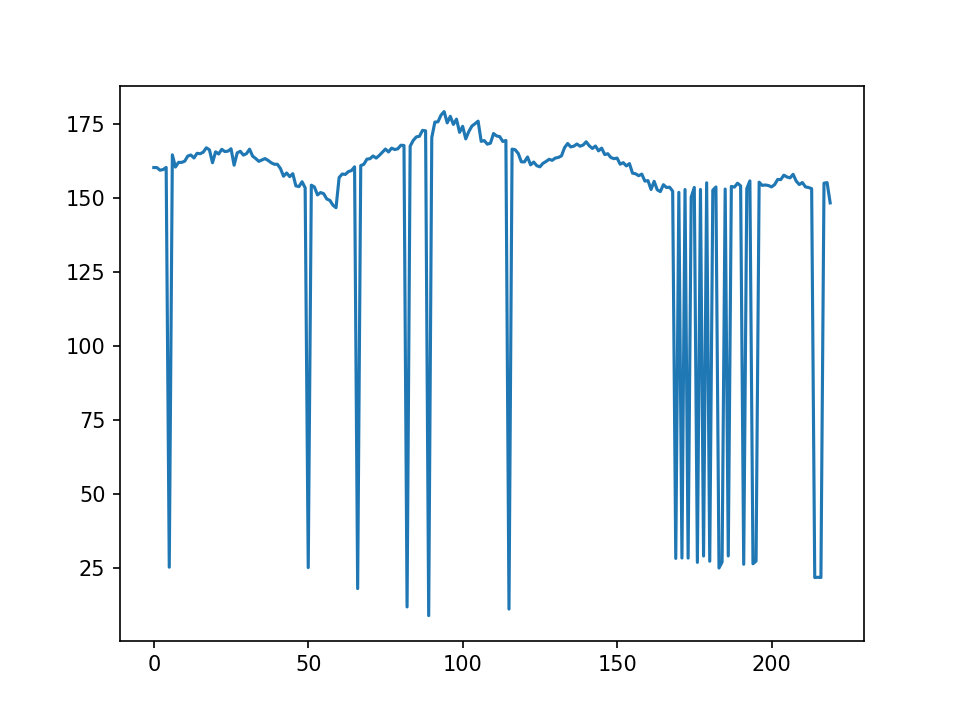

In [683]:
plt.plot(angles_tracker)

<IPython.core.display.Javascript object>


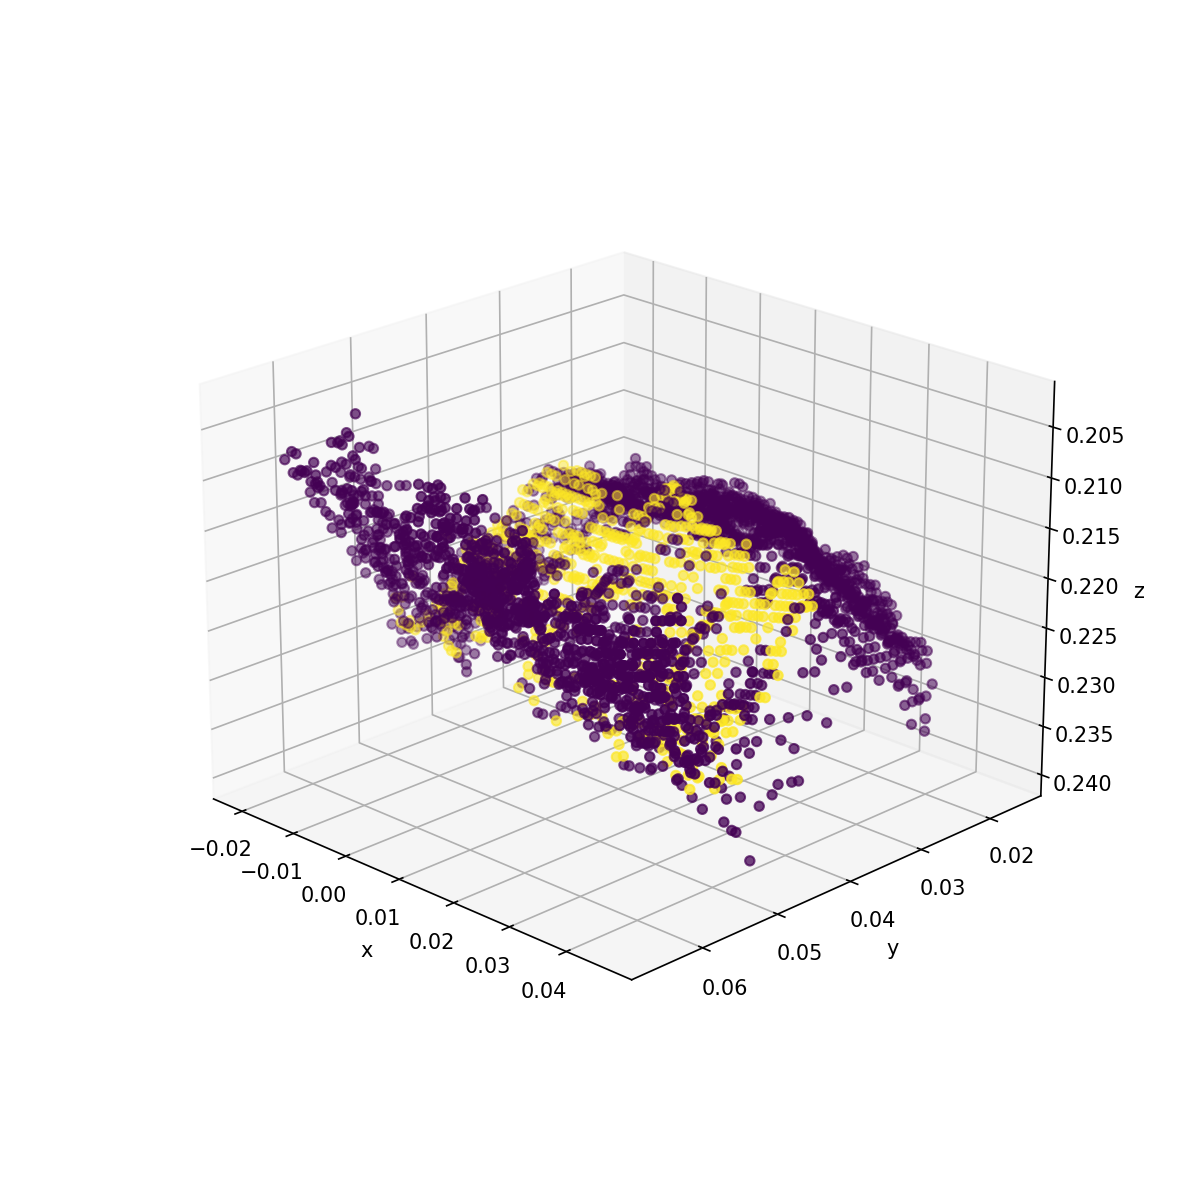

In [674]:
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(8, 8)
ax.view_init(elev=-111, azim=-107)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter3D(pc0[::,0], pc0[::,1], pc0[::,2], c=filtered0[::], depthshade=True)

In [641]:
m, pc.shape, filtered.shape

(array([ 0.03041083, -0.51212887,  0.85837008, -0.20857068]), (428, 3), (428,))

In [648]:
filtered2 = np.abs((pc.dot(m[:3])+m[3])) < 0.0015

<IPython.core.display.Javascript object>


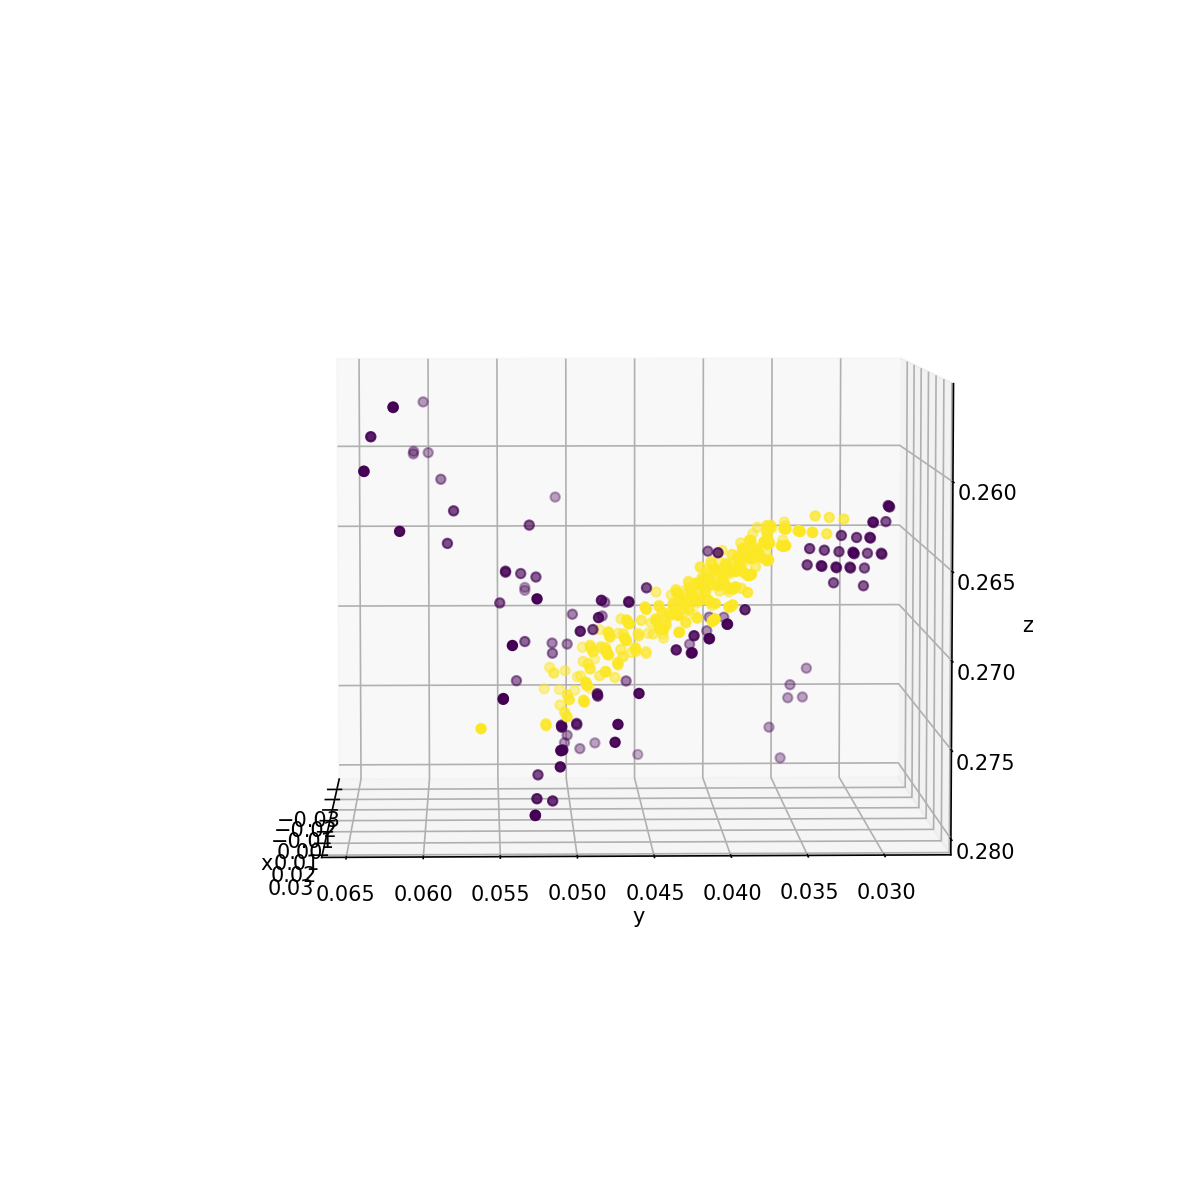

In [649]:
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(8, 8)
ax.view_init(elev=-111, azim=-107)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter3D(pc[::,0], pc[::,1], pc[::,2], c=filtered2[::], depthshade=True)

In [656]:
normal_arr = retrieve_normal(intrinsics_map, depth_map)
#normal_arr = retrieve_normal(intrinsics_map, cv2.filter2D(depth_map, -1, np.ones((3,3))/9))
angle_to_major = filter_surface_normals(normal_arr, unit_direction, tol=35, smooth=[1,0])

In [657]:
vect_arr.shape, normal_arr.shape, depth_map.shape

((512, 512, 3), (512, 512, 3), (512, 512))

<IPython.core.display.Javascript object>


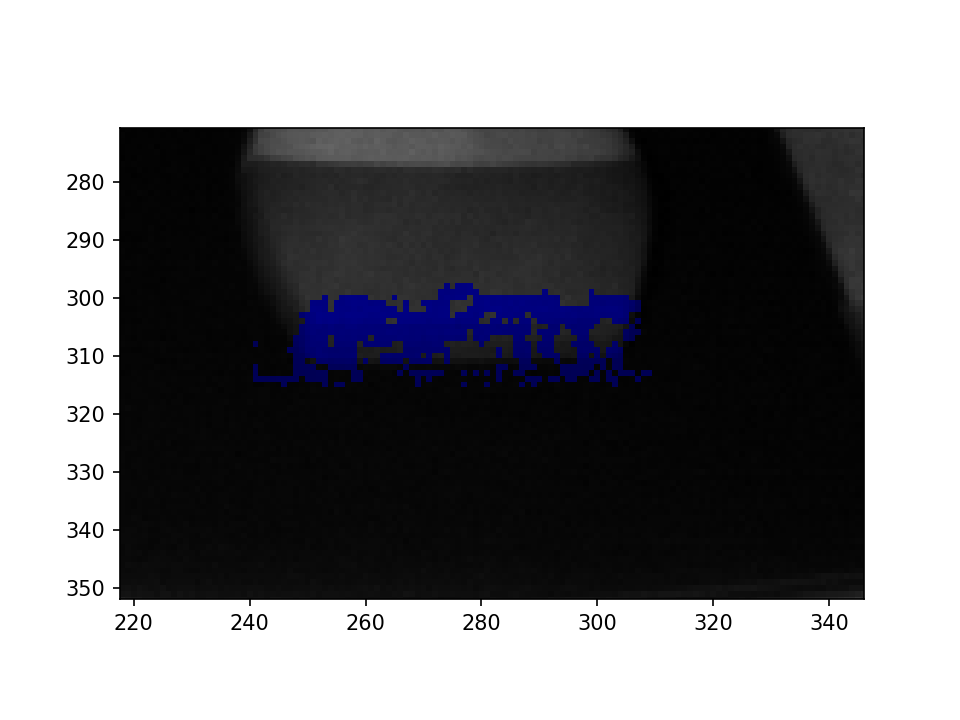

In [678]:
plt.imshow(bright_map1)

In [566]:
plt.close()

In [343]:
render_dist = 0.13
_, filtered = fit_plane_ransac(pc, dist_inlier=0.003)
pc_all = vect_arr.reshape((-1,3))
color_all = bright_map.copy().reshape((-1,1))
dist_to_supp = np.linalg.norm(pc_all - all_supports[0,:], axis=1)
pc_near = pc_all[dist_to_supp < render_dist, :]
color_near = color_all[dist_to_supp < render_dist, :]
filtered.shape, pc_all.shape, dist_to_supp.shape, pc_near.shape, color_near.shape

((475,), (262144, 3), (262144,), (34426, 3), (34426, 1))